<a href="https://colab.research.google.com/github/comeall11/AOHRSI_Kamal_Serge/blob/main/Automated_landslide_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Google Drive and installing necessary libraries

Requirements:
1. [Google Account](https://www.google.com/account/about/)
2. [Google Drive](https://www.google.com/drive/)

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install segmentation_models rasterio geopandas contextily # This line will install the packages/libraries which are not present in Google Colab. Remember that once the session runtime is over, you need to run this cell as well as the one above again.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load the NumPy arrays which contains the training, validation, and testing data

### What is an array?
Arrays are a fundamental data structure, and an important part of most programming languages. In Python, they are containers which are able to store more than one item at the same time. Specifically, they are an ordered collection of elements with every value being of the same data type.

#### The images are already cut into 128x128 patch sizes.

![image.png](https://www.researchgate.net/publication/327941585/figure/fig3/AS:686047130296330@1540577790472/The-architecture-of-the-patch-wise-convolutional-network-This-paper-splits-the-large_W640.jpg)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DL')

In [ ]:
X_train = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/trainX.npy')
Y_train = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/trainY.npy')
X_val = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/valX.npy')
Y_val = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/valY.npy')
X_test = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/testX.npy')
Y_test = np.load(f'/content/drive/MyDrive/DL/Data/Arrays/testY.npy')

print("Shape of the training dataset (satellite image): ", X_train.shape)
print("Shape of the training dataset (label image): ",Y_train.shape)
print("Shape of the validation dataset (satellite image): ",X_val.shape)
print("Shape of the validation dataset (label image): ",Y_val.shape)
print("Shape of the testing dataset (satellite image): ",X_test.shape)
print("Shape of the testing dataset (label image): ",Y_test.shape)

Shape of the training dataset (satellite image):  (1119, 128, 128, 4)
Shape of the training dataset (label image):  (1119, 128, 128, 1)
Shape of the validation dataset (satellite image):  (284, 128, 128, 4)
Shape of the validation dataset (label image):  (284, 128, 128, 1)
Shape of the testing dataset (satellite image):  (355, 128, 128, 4)
Shape of the testing dataset (label image):  (355, 128, 128, 1)


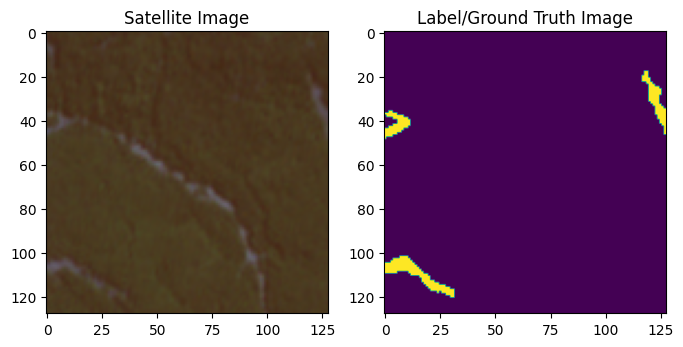

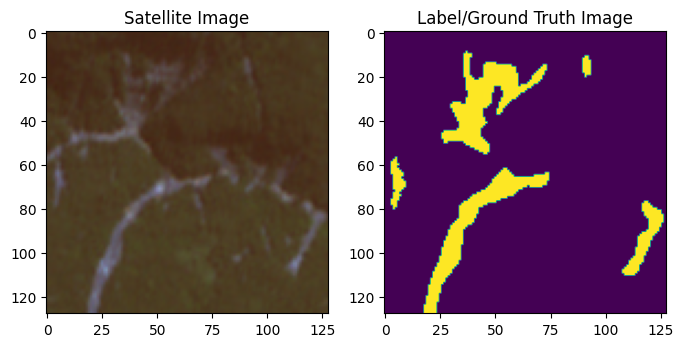

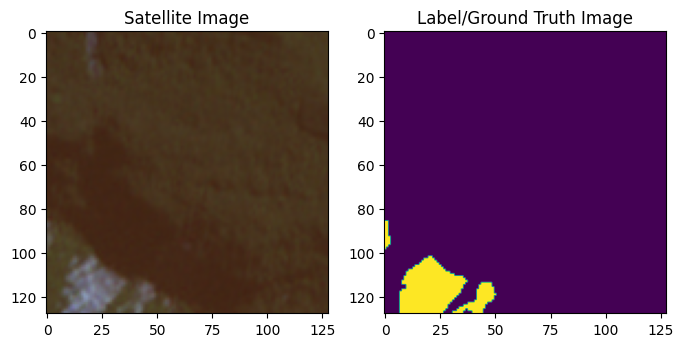

In [ ]:
# Visualise some data
for i in range(3):
    f, axarr = plt.subplots(1,2,figsize=(8,8))
    axarr[0].imshow(X_train[i][:,:,:3])
    axarr[0].set_title("Satellite Image")
    axarr[1].imshow(np.squeeze(Y_train[i]))
    axarr[1].set_title("Label/Ground Truth Image")

# **INITIALIZATION MODEL TRAINING PARAMETERS**

#### **Precision** is a measure of how many of the positive predictions made are correct (true positives).

#### **Recall** is a measure of how many of the positive cases the model correctly predicted, over all the positive cases in the data. It is sometimes also referred to as Sensitivity.

#### **F1-Score** is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean. The formula used for F1-score in this case is:

In [ ]:
# Here we define the evaluation metrics - Precision, Recall, FScore, IoU
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Library with segmentation metrics
import segmentation_models as sm
metrics = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1)]

Segmentation Models: using `tf.keras` framework.


#**WHAT IS A LOSS FUNCTION??**

A loss function is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

Dice Loss is widely used in image segmentation tasks to address the data imbalance problem.

![image](http://mriquestions.com/uploads/3/4/5/7/34572113/steepest-descent-loss-funciton_orig.png)

In [ ]:
# Loss function
import tensorflow.keras.backend as K

smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# **U-Net Segmentation Model**

Here we initialise the U-Net model for training purposes with the data we introduced above.

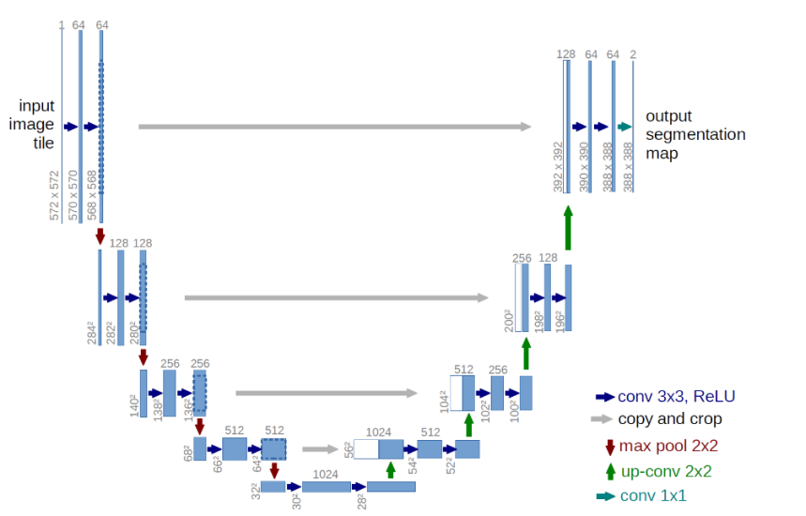

In [ ]:
# Model training - Results are saved in a .csv file

# Size of the tiles
size = X_train.shape[2] # This line takes the value of the 3rd index which in this is taken from X_train shape = 1119, 128, 128, 4, that is 128.

# Image bands
img_bands = X_train.shape[3] # This line takes the value of the 4th index which in this is taken from X_train shape = 1119, 128, 128, 4, that is 4.

# Loss function. We assign the variable called "loss" which takes the dice_loss loss function.
loss=dice_loss

# Number of filters. We set a range of the number of filters for the convolutional layers.
filters = [4, 8, 16, 32]

# Learning rates for the ADAM optimizer that we use in the model. An activation function decides whether a neuron should be activated or not.
# This means that it will decide whether the neuron's input to the network is important or not in the process of prediction using simpler mathematical operations.
# Activation functions helps in maintaining a steady learning capability of the model while also keeping the loss at the minimum.
lr = [10e-3, 5e-4, 10e-4, 5e-5, 10e-5]

# Batch sizes. This considers how many patches the model will take during the training phases. A value of 4 means 4 patches of images (from 1119) will be taken as a batch while training simultaneously.
batch_size = [4, 8, 16, 32]

# Epochs. The number of iterations the model will train.
epochs = 1

# Dictionary that will save the results. We first make an empty dictionary so that later we can save/store all the important configurations that we experimented with and report at the end in nice Excel CSVs and Plots.
dic = {}

# Hyperparameters. These are the keys where the associated information for each hyperparameter will be saved.
dic["model"] = [] # Name of the model
dic["batch_size"] = [] # Batch Size
dic["learning_rate"] = [] # Learning rate
dic["filters"] = [] # Number of filters

# Metrics on the test set. It will save the metrics after evaluating the moedl on the test set.
dic["precision_area"] = []
dic["recall_area"] = []
dic["f1_score_area"] = []

## Here we perform a nested for-loop to check all possible hyperparameter combinations that we set above.

# loop over all the filters in the filter list
for fiilter in filters:
    # loop over the learning rates
    for learning_rate in lr:
        # loop over all batch sizes in batch_size list
        for batch in batch_size:
            print('_______________________________________________________________________________')
            print('Filters: ', fiilter)
            print('Learning rate: ', learning_rate)
            print('Batch size: ', batch)

            # We define the model architecture here.
            def unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):
                inputs = Input(input_size)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(inputs)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv4)
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool4)
                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv5)

                up6 = Conv2D(filtersFirstLayer*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv5))
                merge6 = concatenate([conv4,up6], axis = 3)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge6)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv6)

                up7 = Conv2D(filtersFirstLayer*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv6))
                merge7 = concatenate([conv3,up7], axis = 3)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge7)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv7)

                up8 = Conv2D(filtersFirstLayer*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv7))
                merge8 = concatenate([conv2,up8], axis = 3)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge8)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv8)

                up9 = Conv2D(filtersFirstLayer, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv8))
                merge9 = concatenate([conv1,up9], axis = 3)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge9)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

                model = Model(inputs, conv10)

                # We initialise the ADAM optimizer here with the different learning rates that we assigned earlier.
                model.compile(optimizer = Adam(learning_rate = lr), loss = loss, metrics = metrics)

                #model.summary()

                if(pretrained_weights):
                    model.load_weights(pretrained_weights)

                return model

            # Load the model in a new variable called "model".
            model = unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))

            # Stop the training if the validation loss does not decrease after 30 epochs. This is done to avoid over-fitting of the model. Please find the materials to understand overfitting here: https://www.v7labs.com/blog/overfitting
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure. We choose "val_loss" because we want to monitor the progress of the model while tuning on the validation data set.
                              patience = 30, # how many epochs to continue running the model after not seeing any change in the "val_loss"
                              restore_best_weights = True) # update the model weights

            # Save the models only when validation loss decrease
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/DL/try/weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5',
                                                                  monitor='val_loss', mode='min',verbose=0, save_best_only=True,save_weights_only = True)

            # fit the model with 20% of the dataset used as the validation set
            history = model.fit(X_train,Y_train,
                                batch_size = batch,epochs=epochs,
                                validation_split=0.2, # This is the value that sets the validation split from the training data (X_train)
                                callbacks = [model_checkpoint, early_stop], verbose=1)

            # summarize history for f1-score
            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            # save plots locally
            plt.savefig(f"/content/drive/MyDrive/DL/try/plots/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_f1_score.png")
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"/content/drive/MyDrive/DL/try/plots/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_val_loss.png")
            plt.show()

            # load unet to evaluate the test data
            load_unet = unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            # load the last saved weight from the training
            load_unet.load_weights(f"/content/drive/MyDrive/DL/try/weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5")

           # Here, we evaluate the model performance on the test set, a set of data that the model has never seen before and therefore remains an objective tool to test the performance of the model.
            res_1= load_unet.evaluate(X_test,Y_test)

            # save results on the dictionary and then output them all in a Excel CSV file.
            dic["model"].append("Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["precision_area"].append(res_1[1])
            dic["recall_area"].append(res_1[2])
            dic["f1_score_area"].append(res_1[3])

            # Convert results to a dataframe
            results = pd.DataFrame(dic)
            # Export as csv
            results.to_csv(f'/content/drive/MyDrive/DL/try/csv/results_Unet.csv', index = False)


# **PREDICT LANDSLIDES ON THE TEST SET**

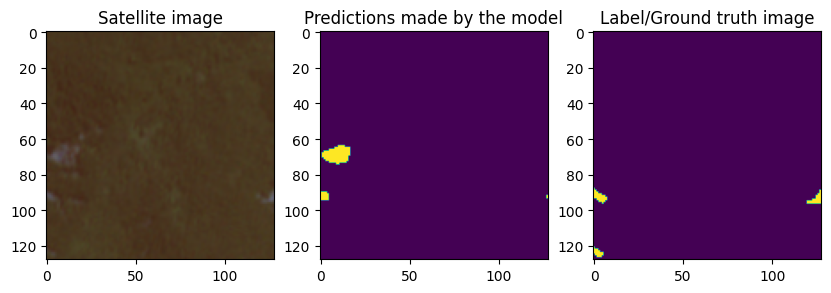

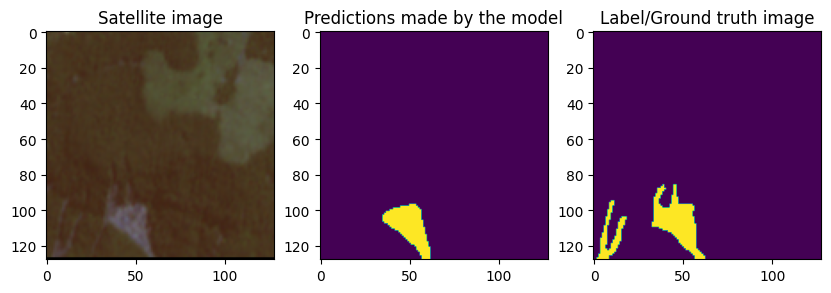

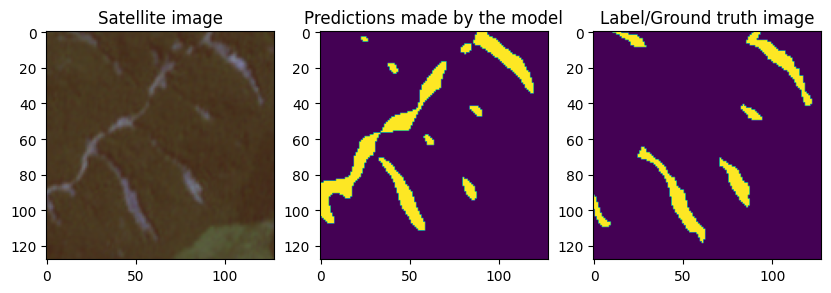

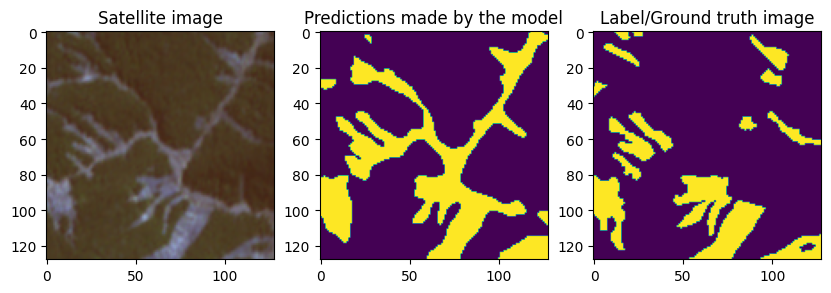

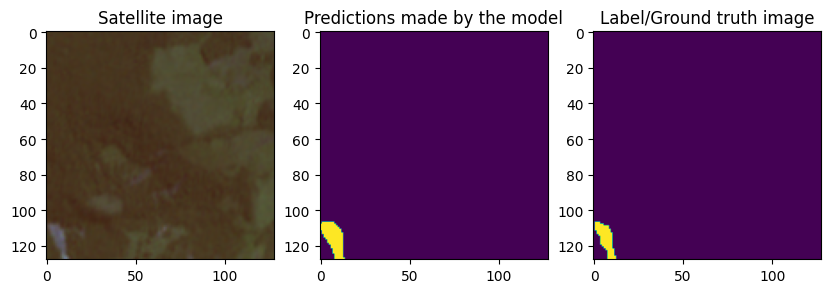

In [ ]:
# Load the best model based on the best performances on the test set (check CSV file and find best model using the highest f1-score value)
# Loading the model weights
unet_best = unet(filtersFirstLayer= 4,lr = 0.0001,input_size=(size,size,img_bands)) # We need to the same number of filters and learning rate of the chosen model to initialise the network.
unet_best.load_weights("/content/drive/MyDrive/DL/Results/weights/unet_size_128_filters_4_batch_size_8_lr_0.0001.hdf5")

no = 5#X_test.shape[0]
# Plot predictions on test set
for i in range(no):
    preds_train_1 = unet_best.predict(np.expand_dims(X_test[i],axis = 0), verbose=0)
    # It's possible to change the 0.5 threshold to improve the results;
    preds_train_t1 = (preds_train_1 > 0.5).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,:3])
    axarr[0].set_title("Satellite image")
    axarr[1].imshow(np.squeeze(preds_train_t1))
    axarr[1].set_title("Predictions made by the model")
    axarr[2].imshow(np.squeeze(Y_test[i]))
    axarr[2].set_title("Label/Ground truth image")

# Inferencing on the Far-west part of Nepal in 2023 after Monsoon

#### Now, since we have a trained model which can very well distinguish between landslide and non-landslide areas after training on this nicely curated dataset, the point is to see if this model can now predict new landslide occurrences in events that occurred recently. In real-case scenarios, we would ideally like to get the landslide "footprints" as accurately and fast as possible for a number of reasons spanning from
1. relief protocols;
2. assessisng damage to elements-at-risk;
3. using the predictions for further predictive modelling, for example, susceptibility or even hazard assessment.


In [ ]:
import rasterio
# Set the required settings
patchsize=128
overlap=24
nbands=4

# Image that you use to predict on (Far_west Nepal)
image_data = rasterio.open("/content/drive/MyDrive/DL/Data/Inference_nepal/npl_infe.tif")
bands = [image_data.read(i+1) for i in range(nbands)]
Xuse = np.stack(bands,axis=2)
NROWS, NCOLS, NBANDS = Xuse.shape
Xuse = np.expand_dims(Xuse, axis=0)
print(f'Shape of the satellite image{Xuse.shape}')

Shape of the satellite image(1, 12647, 19183, 4)


## This code will run the predictions on the image from far-west of Nepal using the best model that we got.


In [ ]:
# Initiate the code with even number divisibility
_,Nrows,Ncols,NBands=Xuse.shape
if Ncols%patchsize!=0 or Nrows%patchsize!=0:
    print("The shape of input image is not divisible by patch size removing last pixels")
    newrow=int(Nrows/patchsize)
    newcol=int(Ncols/patchsize)
    Xuse=Xuse[:,:newrow*patchsize,:newcol*patchsize,:]
    print(f"the shape of new image is {Xuse.shape}")

# Overlapping
_,Nrows,Ncols,NBands=Xuse.shape
itrcol=int((Ncols-patchsize)/(patchsize-overlap))+1
itrrow=int((Nrows-patchsize)/(patchsize-overlap))+1
totalmap=np.zeros((Nrows,Ncols),dtype=np.float32)
halfoverlap=int((overlap/2))
# print(itrcol,itrrow)
for i in range(itrrow):
    if i ==0:
        striptop=i
        stripbottom=patchsize
        #print(striptop,stripbottom)
    else:
        striptop=(patchsize-overlap)*i
        stripbottom=(patchsize-overlap)*i+patchsize
    for j in range(itrcol):
        if j==0:
            stripleft=j
            stripright=patchsize
        else:
          # Prediction
            stripleft=(patchsize-overlap)*j
            stripright=(patchsize-overlap)*j+patchsize
        Xuse_sub=Xuse[:,striptop:stripbottom,stripleft:stripright,:]
        predictions=unet_best.predict_on_batch(Xuse_sub)
        # predictions = (predictions[3] > 0.9).astype(np.uint8)

        # Check the last layer of the array for the above description and change accordingly.
        # print(f'Shape of the image: {predictions.shape}')
        # print(np.unique(predictions))

        # Prediction using the overlaps
        if i==0:
            filltop=int(i)
            fillbottom=int((patchsize-overlap/2))
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,:-halfoverlap,:-halfoverlap,:][0],axis=2)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,:-halfoverlap,halfoverlap:-halfoverlap,:][0], axis=2)

            # print(np.unique(totalmap))
            # break
        else:
            filltop=int((patchsize-overlap/2)+(patchsize-overlap)*(i-1))
            fillbottom=int((patchsize-overlap/2)+(patchsize-overlap)*i)
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,halfoverlap:-halfoverlap,:-halfoverlap,:][0], axis=2)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,halfoverlap:-halfoverlap,halfoverlap:-halfoverlap,:][0], axis=2)

The shape of input image is not divisible by patch size removing last pixels
the shape of new image is (1, 12544, 19072, 4)


### This section converts the predictions to a .TIFF image and an ESRI shapefile which you can use to view in a GIS platform like QGIS or ArcMap/Pro.

In [ ]:
# Convert from float to integer
intmap = np.rint(totalmap)
predictions=intmap

save_file="/content/drive/MyDrive/DL/Results/Prediction/ls_detected.tif" ##Give the save name to save predicted data in here
with rasterio.Env():
    profile = image_data.profile
    profile.update(
        dtype=rasterio.int8,
        count=1,
        width= predictions.shape[-1],
        height= predictions.shape[-2],
        transform= image_data.transform*image_data.transform.scale(0.25,0.25),
        compress='lzw')
    with rasterio.open(save_file, 'w', **profile) as dst:
        dst.write(predictions.astype(rasterio.int8), 1)

In [ ]:
import geopandas as gpd
from rasterio.features import shapes

mask=predictions==1
results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v)
        in enumerate(
            shapes(predictions, mask=mask, transform=image_data.transform)))

geoms = list(results)
gpd_polygonized_raster = gpd.GeoDataFrame.from_features(geoms)
gpd_polygonized_raster = gpd_polygonized_raster.set_crs(image_data.crs)

gpd_polygonized_raster.to_file("/content/drive/MyDrive/DL/Results/Prediction/ls_detected.shp")
print("Shapefile conversion successful !!!")

Shapefile conversion successful !!!


### Just to visualise the prediction alongside the satellite imagery

These is the satellite of the affected region


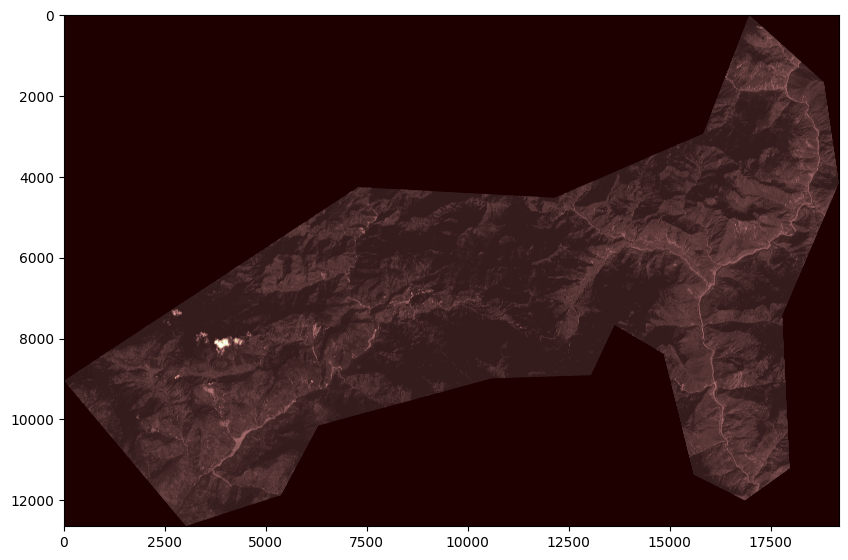

In [26]:
from matplotlib import pyplot
print("This is the satellite of the affected region")
src = rasterio.open("/content/drive/MyDrive/DL/Data/Inference_nepal/npl_infe.tif")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src.read(1),cmap="pink")

These are the detected landslides from the satellite imagery .......


/usr/local/lib/python3.10/dist-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 14 is not valid for the current tile provider (valid zooms: 0 - 13).
  warnings.warn(msg)


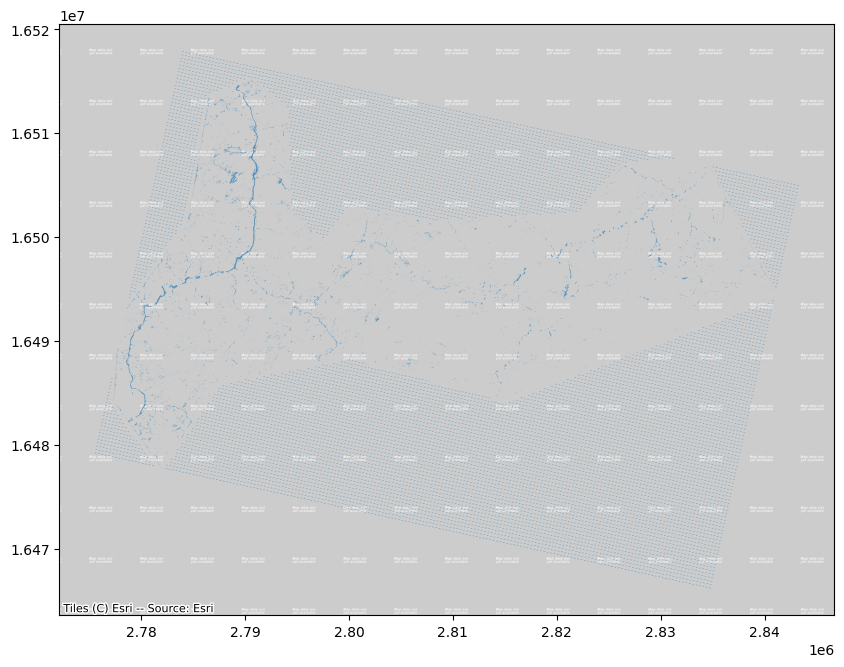

In [27]:
import contextily as cx
print("These are the detected landslides from the satellite imagery .......")
df = gpd.read_file("/content/drive/MyDrive/DL/Results/Prediction/ls_detected.shp")
df_wm = df.to_crs(epsg=32618)
ax=df_wm.plot(legend=True,figsize=(10, 10), alpha=0.7)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)